In [1]:
import ROOT
from iminuit import Minuit, cost
import iminuit
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd

import ROOT as rt
import ROOT as root
from ROOT import TGraphErrors, TCanvas, TLine, TLegend, TF1, gStyle, TH1F,TH1D
from ROOT import TCanvas, TGraph, TLegend, TGraphErrors, TMath
from ROOT import TF1, TH1F,kGreen, TGraphAsymmErrors
from ROOT import gStyle, gPad, gROOT, TStyle, TPaveStats, TPad
gStyle.SetOptStat(0);
gStyle.SetOptFit(1111);
# import root_numpy as npr
# import root_pandas as pdr
# from root_numpy import array2tree

# import ROOT
# import array
# import root_numpy

import types
import array

c = 29.979

Hit = namedtuple("Hit", ["x", "y", "z", "t", "x_err", "y_err", "z_err", "t_err"])

class chi2_track_time:
    def __init__(self, hits):
        self.hits=hits
        self.func_code = iminuit.util.make_func_code(['x0', 'y0', 'z0', 't0', 'vx', 'vy', 'vz'])
    def __call__(self, x0, y0, z0, t0, vx, vy, vz):
        error=0
        for hit in self.hits:
            dt=hit.t-t0
            model_x = x0 + dt*vx
            model_y = y0 + dt*vy
            model_z = z0 + dt*vz
            # error+= np.sum(np.power([(model_t- (hit.t-t0))/hit.t_uncertainty, 
            #                          (model_x-hit.x)/hit.x_uncertainty, 
            #                          (model_z-hit.z)/hit.z_uncertainty],2))
            error+= np.sum(np.power([(model_y-hit.y)/hit.y_err, 
                                     (model_x-hit.x)/hit.x_err, 
                                     (model_z-hit.z)/hit.z_err],2))            
        return error        

def guess_track(hits):
    # Guess initial value of speed
    dt=hits[-1].t-hits[0].t
    vx_init = (hits[-1].x-hits[0].x)/dt
    vy_init = (hits[-1].y-hits[0].y)/dt
    vz_init = (hits[-1].z-hits[0].z)/dt
    v_mod = np.sqrt(vx_init**2+vy_init**2+vz_init**2)
    if v_mod>c:
        vx_init = vx_init*0.99*c/v_mod
        vy_init = vy_init*0.99*c/v_mod
        vz_init = vz_init*0.99*c/v_mod
    return  (hits[0].x, hits[0].y, hits[0].z, hits[0].t, vx_init, vy_init, vz_init)
    
def fit_track(hits, guess=None):
    x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init = guess if guess else guess_track(hits)

    m = Minuit(chi2_track_time(hits),x0=x0_init, y0=y0_init, z0=z0_init, t0=t0_init, vx=vx_init, vy=vy_init, vz=vz_init)
    m.fixed["t0"]=True
    m.limits["x0"]=(-50e3,50e3)
    m.limits["y0"]=(-200e3,200e3)
    m.limits["z0"]=(-30e3,10e3)
    m.limits["t0"]=(-10,100)
    m.limits["vx"]=(-2*c, 2*c)
    m.limits["vy"]=(-2*c, 2*c)
    m.limits["vz"]=(-2*c, 2*c)
    m.errors["x0"]=0.1
    m.errors["y0"]=0.1
    m.errors["z0"]=0.1
    m.errors["t0"]=0.1
    m.errors["vx"] = 0.01
    m.errors["vy"] = 0.01
    m.errors["vz"] = 0.01

    m.migrad()  # run optimiser
    m.hesse()   # run covariance estimator
    
    return m

Welcome to JupyROOT 6.28/10


In [2]:
df = pd.read_csv('truth_offsets.txt',sep=' ') # read in text file containing truth offsets for each channel
# display(df)
lookup = df.set_index('channel_id').T.to_dict('list')
# print(lookup)

In [3]:
tfile = ROOT.TFile.Open("rec_cosmic_run_1.root")
print(tfile.ls())
tfile.GetListOfKeys().Print()
tree_name = tfile.GetListOfKeys()[0].GetName()
print(tree_name)
Tree = tfile.Get(tree_name)
branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
entries = Tree.GetEntries()

print("Branches", branches)
print("# of branches", len(branches))
print("Entries", entries)

vs = []
for ent in range(entries):
    if ent%1000 == 0:
        print("Current Entry: "+str(ent))
    Tree.GetEntry(ent)
    hits = []
    for i in range(len(Tree.Digi_time)):
        actual_time = Tree.Digi_time[i] - lookup[Tree.Digi_det_id[i]][0]
        hits.append(Hit(Tree.Digi_x[i], Tree.Digi_y[i], Tree.Digi_z[i], actual_time, 1,1,1,1))
    m = fit_track(hits)
    v = np.sqrt(m.values["vx"]**2 + m.values["vy"]**2 + m.values["vz"]**2)
    vs.append(v)

tfile.Close()

None
Recorded
Branches ['Digi_x', 'Digi_y', 'Digi_z', 'Digi_time', 'Digi_det_id']
# of branches 5
Entries 46217
Current Entry: 0


/tmp/ipykernel_3052504/146128039.py:35: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = iminuit.util.make_func_code(['x0', 'y0', 'z0', 't0', 'vx', 'vy', 'vz'])


Current Entry: 1000
Current Entry: 2000
Current Entry: 3000
Current Entry: 4000
Current Entry: 5000
Current Entry: 6000
Current Entry: 7000
Current Entry: 8000
Current Entry: 9000
Current Entry: 10000
Current Entry: 11000
Current Entry: 12000
Current Entry: 13000
Current Entry: 14000
Current Entry: 15000
Current Entry: 16000
Current Entry: 17000
Current Entry: 18000
Current Entry: 19000
Current Entry: 20000
Current Entry: 21000
Current Entry: 22000
Current Entry: 23000
Current Entry: 24000
Current Entry: 25000
Current Entry: 26000
Current Entry: 27000
Current Entry: 28000
Current Entry: 29000
Current Entry: 30000
Current Entry: 31000
Current Entry: 32000
Current Entry: 33000
Current Entry: 34000
Current Entry: 35000
Current Entry: 36000
Current Entry: 37000
Current Entry: 38000
Current Entry: 39000
Current Entry: 40000
Current Entry: 41000
Current Entry: 42000
Current Entry: 43000
Current Entry: 44000
Current Entry: 45000
Current Entry: 46000
TFile**		rec_cosmic_run_1.root	
 TFile*		re

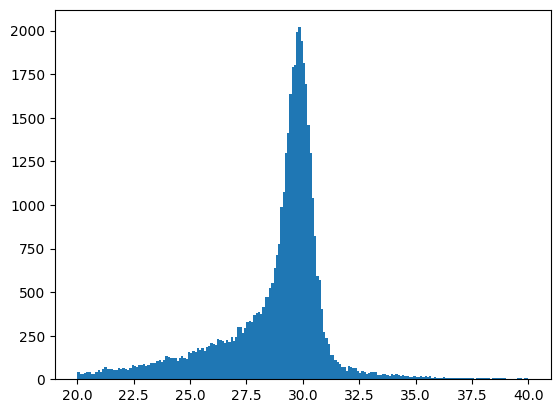

In [4]:
h = plt.hist(vs,bins=200,range=[20,40])

[ 1.84603118e+03  2.98002934e+01 -7.31875981e-01]


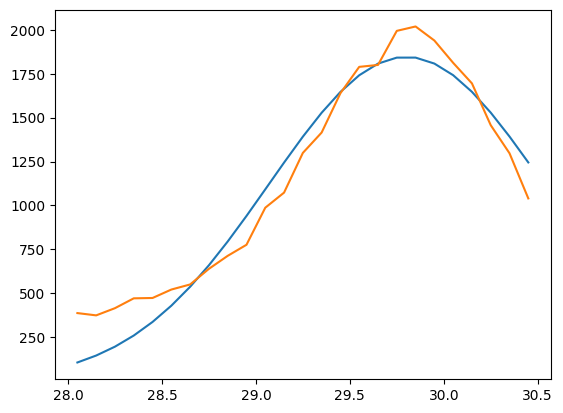

In [5]:
from scipy.optimize import curve_fit

def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

xdata = 0.5*(h[1][:-1]+h[1][1:])
ydata = h[0]
fit_range = [28,30.5]
mask=(xdata>=fit_range[0])&(xdata<=fit_range[1])
xdata=xdata[mask]
ydata=ydata[mask]
# sigma=np.sqrt(ydata)
popt,pcov = curve_fit(gauss,xdata,ydata,p0=[max(vs),np.mean(vs),5])
print(popt)
plt.plot(xdata,gauss(xdata,popt[0],popt[1],popt[2]))

plt.plot(xdata,ydata)

In [6]:
np.mean(vs)

28.576546419040834

In [7]:
def GetBinCenters(h):
    Nbins=h.GetNbinsX()
    bincenters=np.array([])
    for i in np.arange(1,Nbins+1):
        i=int(i)
        bincenters=np.append(bincenters,h.GetBinCenter(i))  
        
    return bincenters

def GetBinEdges(h):
    Nbins=h.GetNbinsX()
    bin_edges_low=np.array([])
    bin_widths = np.array([])
    for i in np.arange(1,Nbins+1):
        i=int(i)
        bin_edges_low=np.append(bin_edges_low,h.GetBinLowEdge(i))  
        bin_widths=np.append(bin_widths,h.GetBinWidth(i))  
    bin_edges_low=np.append(bin_edges_low,bin_edges_low[-1]+bin_widths[-1])
    return bin_edges_low

def GetBinContents(h):
    Nbins=h.GetNbinsX()
    bincenters=np.array([])
    n=np.array([])
    for i in np.arange(1,Nbins+1):
        i=int(i)
        n=np.append(n,h.GetBinContent(i))        
    return n

def GetBinErrors(h):
    Nbins=h.GetNbinsX()
    bincenters=np.array([])
    errs=np.array([])
    for i in np.arange(1,Nbins+1):
        i=int(i)
        errs=np.append(errs,h.GetBinError(i))        
    return errs

def get_info_c(h):
    """
    Return the bin content, bin centers and bin errors of a histogram
    """
    n,bincenters,errs = GetBinContents(h),GetBinCenters(h),GetBinErrors(h)
    return n,bincenters,errs

def get_info(h):
    """
    Return the bin content, bin edges and bin errors of a histogram
    """    
    n,ibins,errs = GetBinContents(h),GetBinEdges(h),GetBinErrors(h)
    return n,ibins,errs


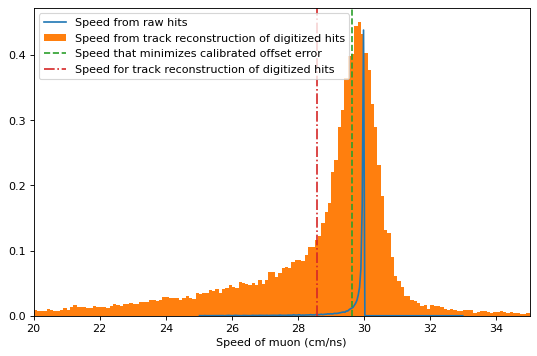

In [8]:
hist_filename = "velocity_hist.root"
hfile = ROOT.TFile(hist_filename,'READ')
vhist = hfile.Get("velocities")
ydata = np.divide(GetBinContents(vhist),np.sum(GetBinContents(vhist)))
plt.figure(figsize=(8, 5), dpi=80)
plt.plot(GetBinCenters(vhist),ydata,label="Speed from raw hits")
plt.hist(vs,bins=200,range=[20,40],density=True,label="Speed from track reconstruction of digitized hits")
plt.axvline(29.637525010406176,color="C2",linestyle="--",label="Speed that minimizes calibrated offset error")
plt.axvline(28.576546419040834,color="C3",linestyle="-.",label="Speed for track reconstruction of digitized hits")
plt.xlim(20,35)
plt.xlabel("Speed of muon (cm/ns)")
plt.legend()
plt.show()

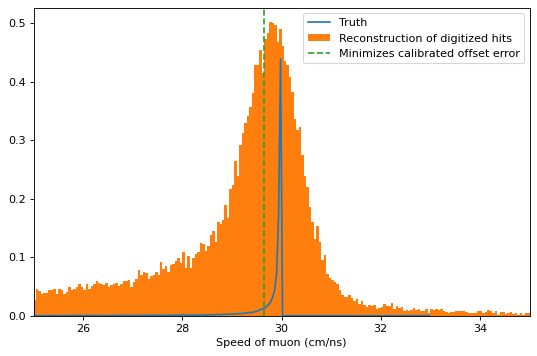

In [14]:
hist_filename = "velocity_hist.root"
hfile = ROOT.TFile(hist_filename,'READ')
vhist = hfile.Get("velocities")
ydata = np.divide(GetBinContents(vhist),np.sum(GetBinContents(vhist)))
plt.figure(figsize=(8, 5), dpi=80)
plt.plot(GetBinCenters(vhist),ydata,label="Truth")
plt.hist(vs,bins=200,range=[25,35],density=True,label="Reconstruction of digitized hits")
plt.axvline(29.65013710142882,color="C2",linestyle="--",label="Minimizes calibrated offset error")
# plt.axvline(28.576546419040834,color="C3",linestyle="-.",label="Speed for track reconstruction of digitized hits")
plt.xlim(25,35)
plt.xlabel("Speed of muon (cm/ns)")
plt.legend()
plt.savefig("rec_fit_plot.png")
plt.show()
